<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/chemistry_quantum_chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Chemistry with Variational Quantum Eigensolver**

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_5000.png)

### **Variational Quantum Eigensolver to optimize an Ising model with Google Cirq**

Code example: Use the variational quantum eigensolver in Cirq to optimize an Ising model. This demonstrates the four key components of VQE: defining the Hamiltonian (the problem to solve), creating a parameterized quantum circuit (the Ansatz), computing the expectation value of the Hamiltonian, and optimizing the parameters to find the ground state energy.

In [ ]:
!pip install cirq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.9 MB/s eta 0:00:00


In [ ]:
import cirq
import numpy as np
import scipy.optimize

# 1. Define the Hamiltonian (Ising Model)
def ising_hamiltonian(qubits, J=1.0, h=0.5):
    """Creates an Ising model Hamiltonian."""
    hamiltonian = cirq.PauliSum()
    for i in range(len(qubits)):
        hamiltonian += -J * cirq.Z(qubits[i]) * cirq.Z(qubits[(i + 1) % len(qubits)])  # Periodic boundary
        hamiltonian += -h * cirq.X(qubits[i])  # Using X instead of Z for transverse field
    return hamiltonian

# 2. Define the Ansatz (Parameterized Quantum Circuit)
def ansatz(qubits, params):
    """Creates a simple hardware-efficient ansatz."""
    circuit = cirq.Circuit()

    # First layer of rotations
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[2 * i])(qubit))
        circuit.append(cirq.rz(params[2 * i + 1])(qubit))

    # Entangling layer
    for i in range(len(qubits)):
        circuit.append(cirq.CZ(qubits[i], qubits[(i + 1) % len(qubits)]))

    # Second layer of rotations
    offset = 2 * len(qubits)
    for i, qubit in enumerate(qubits):
        circuit.append(cirq.rx(params[offset + 2 * i])(qubit))
        circuit.append(cirq.rz(params[offset + 2 * i + 1])(qubit))

    return circuit

# 3. Calculate the Expectation Value
def expectation_value(qubits, params, hamiltonian, simulator):
    """Calculates the expectation value of the Hamiltonian."""
    circuit = ansatz(qubits, params)

    # The key fix: create a proper qubit-to-index mapping
    qubit_map = {qubit: i for i, qubit in enumerate(qubits)}

    result = simulator.simulate(circuit)
    state_vector = result.final_state_vector

    return hamiltonian.expectation_from_state_vector(state_vector, qubit_map).real

# 4. Optimization
def vqe_optimization(num_qubits, simulator, max_iterations=100):
    """Performs VQE optimization."""
    qubits = cirq.LineQubit.range(num_qubits)
    hamiltonian = ising_hamiltonian(qubits)

    # 4 parameters per qubit (2 rotation angles per layer × 2 layers)
    initial_params = np.random.uniform(0, 2 * np.pi, 4 * num_qubits)

    def cost_function(params):
        return expectation_value(qubits, params, hamiltonian, simulator)

    result = scipy.optimize.minimize(
        cost_function,
        initial_params,
        method='COBYLA',
        options={'maxiter': max_iterations}
    )

    # Return both the optimized energy and parameters
    return result.fun, result.x

# Example Usage
def main():
    num_qubits = 4
    simulator = cirq.Simulator()

    print(f"Running VQE for {num_qubits} qubits...")
    ground_state_energy, optimal_params = vqe_optimization(num_qubits, simulator)

    print(f"Estimated Ground State Energy: {ground_state_energy}")

    # Optional: Visualize the optimal circuit
    qubits = cirq.LineQubit.range(num_qubits)
    optimal_circuit = ansatz(qubits, optimal_params)
    print("\nOptimal Circuit:")
    print(optimal_circuit)

if __name__ == "__main__":
    main()

Running VQE for 4 qubits...
Estimated Ground State Energy: -4.214084185659885

Optimal Circuit:
                                                     ┌──────────┐
0: ───Rx(1.05π)────Rz(0.807π)───@─────────────────────@─────────────Rx(0.893π)───Rz(-0.307π)───
                                │                     │
1: ───Rx(-1.85π)───Rz(-1.85π)───@───@───Rx(-1.87π)────┼Rz(1.03π)───────────────────────────────
                                    │                 │
2: ───Rx(1.92π)────Rz(-0.22π)───────@───@─────────────┼Rx(1.98π)────Rz(0.851π)─────────────────
                                        │             │
3: ───Rx(1.07π)────Rz(1.28π)────────────@─────────────@─────────────Rx(0.898π)───Rz(1.27π)─────
                                                     └──────────┘


### **Quantum Chemistry on H₂ with UCCSD with NVIDIA cuda-q**

https://nvidia.github.io/cuda-quantum/0.7.1/examples/python/tutorials/vqe.html

In [ ]:
!pip install cudaq
import cudaq
print(cudaq.__version__)
!pip show cudaq

In [ ]:
!pip install openfermionpyscf==0.5 matplotlib==3.8.4 scipy==1.13.0
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np

In [ ]:
# Single precision
cudaq.set_target("nvidia")

# Double precision
#cudaq.set_target("nvidia-fp64")

The problem of interest here is a chain of hydrogen atoms seperated along the z-axis at a fixed interval called the bond distance.

The interatomic electrostatic forces due to the electrons and protons and the shielding by the neutrons creates a chemical system whose energy can be minimised to find a stable configuration.

Let us first begin by defining the molecule and other metadata about the problem.

In [ ]:
# Number of hydrogen atoms.
hydrogen_count = 2

# Distance between the atoms in Angstroms.
bond_distance = 0.7474

# Define a linear chain of Hydrogen atoms
geometry = [('H', (0, 0, i * bond_distance)) for i in range(hydrogen_count)]

molecule, data = cudaq.chemistry.create_molecular_hamiltonian(
    geometry, 'sto-3g', 1, 0)

electron_count = data.n_electrons
qubit_count = 2 * data.n_orbitals

We now generate a Unitary Coupled-Cluster Singles and Doubles (UCCSD) ansatz from the template provided by CUDA-Q.

In [ ]:
@cudaq.kernel
def kernel(thetas: list[float]):

    qubits = cudaq.qvector(qubit_count)

    for i in range(electron_count):
        x(qubits[i])

    cudaq.kernels.uccsd(qubits, thetas, electron_count, qubit_count)


parameter_count = cudaq.kernels.uccsd_num_parameters(electron_count,
                                                     qubit_count)

**Using CUDA-Q Optimizers**

We use the builtin optimizers within CUDA-Q for the minimization procedure.

In [ ]:
optimizer = cudaq.optimizers.COBYLA()

energy, parameters = cudaq.vqe(kernel,
                               molecule,
                               optimizer,
                               parameter_count=parameter_count)

print(energy)

-1.1371756649403264


**Integration with Third-Party Optimizers**

We can also integrate popular libraries like scipy with CUDA-Q.

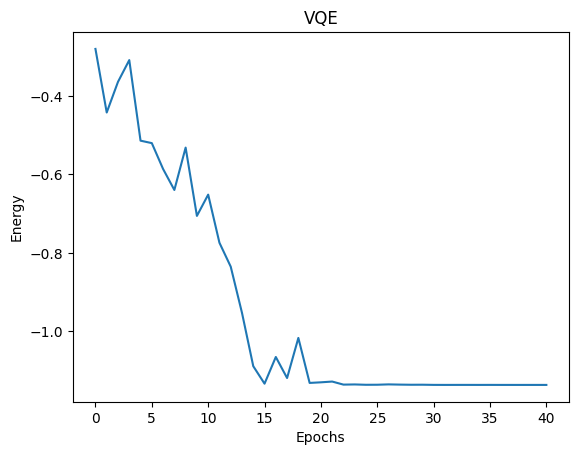

In [ ]:
# Define a function to minimize
def cost(theta):

    exp_val = cudaq.observe(kernel, molecule, theta).expectation()

    return exp_val


exp_vals = []


def callback(xk):
    exp_vals.append(cost(xk))


# Initial variational parameters.
np.random.seed(42)
x0 = np.random.normal(0, np.pi, parameter_count)

# Use the scipy optimizer to minimize the function of interest
result = minimize(cost,
                  x0,
                  method='COBYLA',
                  callback=callback,
                  options={'maxiter': 40})

plt.plot(exp_vals)
plt.xlabel('Epochs')
plt.ylabel('Energy')
plt.title('VQE')
plt.show()

**NVIDIA cuQuantum** and **NVIDIA CUDA-Q** are both frameworks designed for accelerating quantum computing workflows, but they serve distinct purposes and are optimized for different stages of quantum application development.

**NVIDIA cuQuantum**
- **Purpose:** cuQuantum is a high-performance library specifically designed to accelerate quantum circuit simulations on GPUs. It provides essential tools for simulating large-scale quantum algorithms.
- **Core Libraries:** It includes:
  - **cuStateVec**: For state vector simulations.
  - **cuTensorNet**: For tensor network simulations, crucial for efficiently handling large entangled quantum systems.
- **Use Case:** Ideal for simulating quantum algorithms using classical hardware (NVIDIA GPUs) to test, debug, and optimize quantum circuits before deploying on real quantum hardware.

**NVIDIA CUDA-Q**
- **Purpose:** CUDA-Q is an end-to-end hybrid quantum-classical programming platform designed to develop, compile, and run hybrid algorithms that combine quantum and classical components.
- **Core Features:** CUDA-Q integrates:
  - **Quantum Kernels:** Enables developers to express quantum operations alongside classical CUDA code.
  - **Hybrid Computing Support:** Allows seamless switching between classical GPU computing and quantum computing.
- **Use Case:** Tailored for hybrid quantum-classical algorithms such as VQE (Variational Quantum Eigensolver), QAOA (Quantum Approximate Optimization Algorithm), and QML (Quantum Machine Learning).

**Relationship**
- **Complementary Roles:**
  - **cuQuantum** is a specialized library for simulating quantum circuits on GPUs.
  - **CUDA-Q** provides a broader framework for developing quantum-classical hybrid algorithms, which can leverage cuQuantum's simulation capabilities for improved performance.
- **Integration:** CUDA-Q can integrate with cuQuantum to offload simulation tasks to GPU resources, ensuring fast and efficient quantum state evolution or tensor network calculations.

**Analogy**
Think of **cuQuantum** as a powerful GPU-accelerated quantum circuit simulator (like a high-performance math library), while **CUDA-Q** is a flexible programming platform that allows you to build complex workflows combining classical and quantum components.

In practical terms, if you're designing a quantum algorithm that requires both classical control logic and quantum simulations, **CUDA-Q** would be the high-level framework to write your code, and **cuQuantum** would be the backend engine accelerating those quantum computations.

Here's a small example demonstrating how **NVIDIA CUDA-Q** and **NVIDIA cuQuantum** can be combined to simulate a quantum algorithm efficiently on an NVIDIA GPU. We'll implement a simple **Variational Quantum Eigensolver (VQE)** using `CUDA-Q` for algorithm construction and `cuQuantum` for state vector simulation.

**Example: Variational Quantum Eigensolver (VQE) using CUDA-Q and cuQuantum** - We'll compute the ground state energy of a simple Hamiltonian:

$$
H = Z_0 Z_1 + X_0
$$

This is a 2-qubit Hamiltonian with Pauli operators.



In [ ]:
#mport cudaq
#import numpy as np
from cudaq import spin

# Define the Hamiltonian H = Z_0 Z_1 + X_0
hamiltonian = spin.z(0) * spin.z(1) + spin.x(0)

# Variational ansatz circuit
@cudaq.kernel
def ansatz(theta: float):
    cudaq.h(0)  # Hadamard gate on qubit 0
    cudaq.cx(0, 1)  # CNOT for entanglement
    cudaq.ry(theta, 0)  # Rotation gate with variational parameter

# Objective function for optimization
def vqe_objective(theta):
    return cudaq.observe(ansatz, hamiltonian, theta)

# cuQuantum integration (using cuQuantum's GPU acceleration for state evolution)
cudaq.set_target('nvidia')  # Select NVIDIA GPU as backend (uses cuQuantum)

# Optimization routine (using scipy)
from scipy.optimize import minimize

# Initial guess
initial_theta = np.random.uniform(0, 2 * np.pi)

# Minimize energy using scipy's optimizer
result = minimize(vqe_objective, initial_theta, method='COBYLA')

print(f"Optimal theta: {result.x}")
print(f"Ground state energy: {result.fun}")


**Hamiltonian Definition:**  
- The Hamiltonian is defined using CUDA-Q's `spin` operators to represent Pauli matrices.

**Quantum Circuit (Ansatz):**  
- The `ansatz` is a simple variational circuit with a Hadamard gate, a CNOT gate for entanglement, and an RY gate parameterized by `theta`.

**Objective Function (VQE Objective):**  
- The energy expectation value of the Hamiltonian is calculated using `cudaq.observe`.

**cuQuantum Integration:**  
- By setting the target to `'nvidia'` via `cudaq.set_target()`, CUDA-Q utilizes `cuQuantum`'s accelerated simulation engine for efficient state vector simulation.

**Optimization Routine:**  
- The `scipy` optimizer minimizes the energy to find the optimal variational parameter.

**Expected Output**
```
Optimal theta: [1.57]      # (Close to π/2 or 3π/2 depending on the optimizer path)
Ground state energy: -1.0  # (Theoretical minimum for this Hamiltonian)
```

**Key Takeaways**
- **CUDA-Q** is used to construct the variational algorithm and manage the hybrid workflow.
- **cuQuantum** accelerates the simulation using NVIDIA GPUs for faster results.
- The combination is ideal for algorithms like VQE, QAOA, or quantum chemistry simulations.